In [1]:
%load_ext autoreload
%autoreload 2

# Runners

After you have defined the form of your `SimulationState`, the shape of the `Lattice`, `PeriodicStructure` and `Neighborhood` and the `Controller` that implements your update rule, you are ready to run your simulation! The entity responsible for running the simulation is called a `Runner`. In `pylattica` there are two types of runners which run the simulation differently.

1. `SynchronousRunner` - This runner calculates and applies updates to _every site at once_ during each simulation step.
2. `AsynchronousRunner` - This runner calculates and applies updates to _a single site at a time_ during each simulation step.

The `SynchronousRunner` behaves like a typical cellular automaton would. It's updates can be parallelized. The `AsynchronousRunner` is useful for implementing Monte Carlo type simulations, or "asynchronous automata", in which multiple cell states are updated during a single invocation of the update rule.

## Set up
Before we dive into these distinctions, let's set up a small 2D square grid structure using some of the helper classes provided by `pylattica`.

In [2]:
from pylattica.structures.square_grid import SimpleSquare2DStructureBuilder

structure = SimpleSquare2DStructureBuilder().build(10)

Let's also set up a [Von Neumann neighborhood](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood) to use here (also using a `pylattica` helper).

In [3]:
from pylattica.structures.square_grid.neighborhoods import VonNeumannNbHood2DBuilder

nbhood = VonNeumannNbHood2DBuilder().get(structure)

100%|████████████████████████████████████| 100/100 [00:00<00:00, 18416.26it/s]


And finally, let's agree on a simulation state where the state at each cell looks like this:
```
{
    "value": %some integer value%
}
```

Let's also agree that the values will fall within the range 1 - 10.

With that, we can construct a starting state for our simulation.

In [4]:
from pylattica.core import SimulationState

starting_state = SimulationState.from_struct(structure)

And assign random values between 1 and 10 to each site in the structure. I'm putting this in a function so we can reuse it later in the guide.

In [5]:
import random

def set_random_state(state):
    for site_id in structure.site_ids:
        state.set_site_state(site_id, {
            "value": random.randint(1,10)
        })

set_random_state(starting_state)

We can visualize this state by creating a color scale corresponding to the sites 1 through 10:

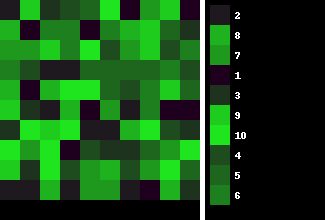

In [6]:
from pylattica.visualization import SquareGridArtist2D, DiscreteCellArtist

color_scale = {}

for i in range(1,11):
    color_scale[i] = (30, int((i - 1) * 255/10), 30)
    
cell_artist = DiscreteCellArtist(color_map = color_scale, state_key="value")
step_artist = SquareGridArtist2D(structure, cell_artist)

step_artist.jupyter_show(starting_state, cell_size=20)

## Synchronous Controller and Evolution

To demonstrate the `SynchronousRunner`, we need an update rule that only affects the state of a single site at a time. A good simple example would be: the future value at a cell is given by incrementing the previous value, unless the value is at a maximum (10).

Let's implement this rule in a controller.

In [7]:
from pylattica.core import BasicController

class SyncController(BasicController):
    
    def get_state_update(self, site_id: int, prev_state: SimulationState):
        prev_site_val = prev_state.get_site_state(site_id).get("value")
        if prev_site_val < 10:
            new_site_val = prev_site_val + 1
        else:
            new_site_val = prev_site_val
            
        return {
            "value": new_site_val
        }

And now we can instantiate a `SynchronousRunner` and run our simulation for 10 steps. 

> **NOTE**: Since every site is updated during each step, we expect every site to have a value of 10 by the end.

Let's generate a new starting state and look at it so we know where we are starting from?

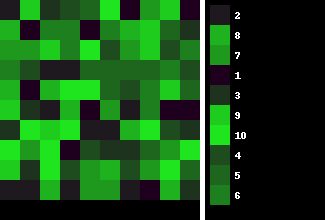

In [8]:
sync_starting_state = SimulationState.from_struct(structure)
set_random_state(sync_starting_state)

step_artist.jupyter_show(starting_state, cell_size=20)

And now let's run for 10 steps:

In [9]:
from pylattica.core.runner import SynchronousRunner

sync_runner = SynchronousRunner()
sync_cont = SyncController()
num_steps = 10

sync_result = sync_runner.run(starting_state, sync_cont, num_steps)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 9754.20it/s]


Finally, we can visualize the last step of this simulation:

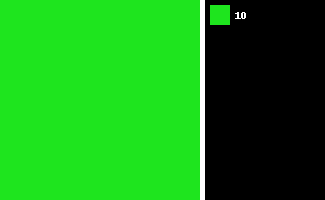

In [10]:
step_artist.jupyter_show(sync_result.last_step)

As expected, every cell has been incremented to 10.

We can also look at an intermediate step in the result:

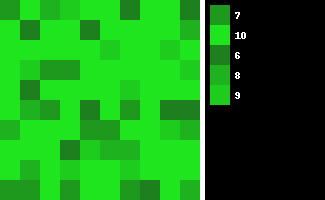

In [11]:
step_artist.jupyter_show(sync_result.get_step(5))

As we expect, there are no cell states below 5 since every cell has been updated at least 5 times by this point.

## Asynchronous Controller and Evolution

We will continue our demonstration of `Runner` objects using the same structure and simulation state seen above, but we will tweak our update rule slightly.

First, instead of incrementing by one during every update, let's say each update will _randomly_ increment or decrement the cell it's applied to.

_Additionally,_ assume we want to conserve the sum of the values present in our simulation. In other words, if at any simulation step, we added up the values held by every cell, we would expect to see the same total.

This would be impossible to achieve with a `SynchronousController` because the total value is a _conserved quantity_. The `SynchronousController` updates every site at once and therefore cannot coordinate site changes. There is no way to conserve a quantity unless we know all the changes that will take place during a given simulation step. This situation is encountered frequently - for instance, in the case of an adsorbed atom moving around on the surface of a crystal, the movement can only be represented by updating neighboring site states simultaneously.

Note that we are removing the bounds on possible values, so our color scale may not be relevant.

Let's make this concrete by implementing the `Controller` that does this.

In [26]:
class AsyncController(BasicController):
    
    def get_state_update(self, site_id: int, prev_state: SimulationState):
        prev_site_val = prev_state.get_site_state(site_id).get("value")
        
        neighbors = nbhood.neighbors_of(site_id)
        rand_nb_id = random.choice(neighbors)
        
        prev_nb_val = prev_state.get_site_state(rand_nb_id).get("value")
        
        direction = random.choice([-1, 1])
        new_site_val = prev_site_val + direction
        new_nb_val = prev_nb_val - direction
        
        return {
            site_id: {
                "value": new_site_val
            },
            rand_nb_id: {
                "value": new_nb_val
            }   
        }

We also need a new color scale for this. Here's a color scale where the intensity of the green is related to the absolute value of the cell's state.

In [27]:
import math

color_scale = {}

b = 30

for i in range(-b, b + 1):
    color_scale[i] = (30, int(math.fabs(i - 1) * 255/(b)), 30)
    
legend = {}

for i in range(-b, b + 1, int((b+b)/ 10)):
    legend[str(i)] = color_scale[i]

cell_artist = DiscreteCellArtist(color_map = color_scale, state_key="value", legend = legend)
step_artist = SquareGridArtist2D(structure, cell_artist)

Additionally, let's create a starting state where every cell value is 0.

In [28]:
async_starting_state = SimulationState.from_struct(structure)

for site_id in structure.site_ids:
    async_starting_state.set_site_state(site_id, { "value": 0 })

We can see by visualization that every site has a value of 0:

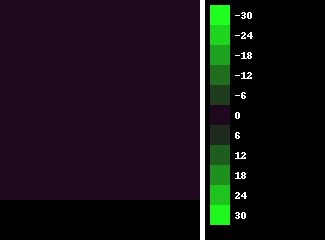

In [29]:
step_artist.jupyter_show(async_starting_state, cell_size=20)

But we can also make a helper function that adds the state values up to see that the total is 0:

In [30]:
def get_total(state: SimulationState):
    total = 0
    for state in state.all_site_states():
        total += state.get("value")
    return total

print("The total of all sites for the starting state is:", get_total(sync_starting_state))

The total of all sites for the starting state is: 0


Great, as expected, the total is zero. Now let's run our simulation and see how this changes.

In [32]:
from pylattica.core.runner import AsynchronousRunner

runner = AsynchronousRunner()
controller = AsyncController()
num_steps = 100

async_result = runner.run(async_starting_state, controller, num_steps)

After 100 steps, we see that values have started to slightly diverge from 0:

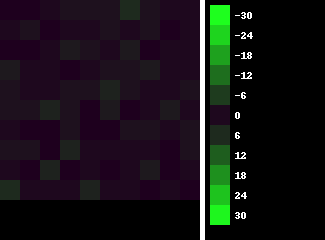

In [33]:
step_artist.jupyter_show(async_result.last_step, cell_size=20)

But the total is still zero!

In [34]:
print("Total after 100 steps:", get_total(async_result.last_step))

Total after 100 steps: 0


Let's run for 10000 steps and see what the result is:

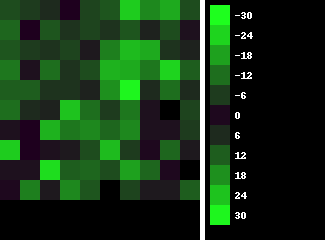

Total after 10000 steps: 0


In [40]:
async_result = runner.run(async_starting_state, controller, 10000)
step_artist.jupyter_show(async_result.last_step, cell_size=20)
print("Total after 10000 steps:", get_total(async_result.last_step))

The sum is still 0 even though the value of many of these cells has moved significantly away from 0.

This illustrates how an `AsynchronousRunner` can be used to implement quantity conservation.